# Credit Card Fraud Detection

## 0. Setting the Scene

In [1]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0
# SMOTE를 사용해 클래스 불균형을 해결하고, K-최근접 이웃(KNN) 분류기를 학습하는 코드

  Using cached imbalanced_learn-0.12.0-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.12.0-py3-none-any.whl (257 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.14.0
    Uninstalling imbalanced-learn-0.14.0:
      Successfully uninstalled imbalanced-learn-0.14.0


In [2]:
!pip install -U lightgbm xgboost imbalanced-learn

  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.14.0-py3-none-any.whl (239 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.0
    Uninstalling imbalanced-learn-0.12.0:
      Successfully uninstalled imbalanced-learn-0.12.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [5]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

## 1. EDA

### 1.0 exploring the data

* 각 피처에 대한 이해도, 데이터의 분포와 특성을 파악하기 위한 시각화, 이를 통하여 유의미한 인사이트의 도출
* especially fraud data를 확인하는 경우, 정상 데이턱의 수가 이상 데이터의 수보다 압도적으로 많음 (지도학습을 할 경우 틁히, 극도로 불균형한 데이블 값을 극복하기 위해 충분한 양의 데이터가 필요함)
* 샘플링 기법의 활용 (오버 샘플링 VS 언더 샘플링)

In [6]:
print(train.shape, test.shape)
train.head()

(170883, 32) (113923, 31)


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [8]:
train["id"].max(), test["id"].min()

(170882, 170883)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [10]:
train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [11]:
train["Class"].value_counts(normalize=True)*100
#불균형의 정도를 확인

,proportion
Class,
0,99.78933
1,0.21067


### 1.1. 이상치 확인

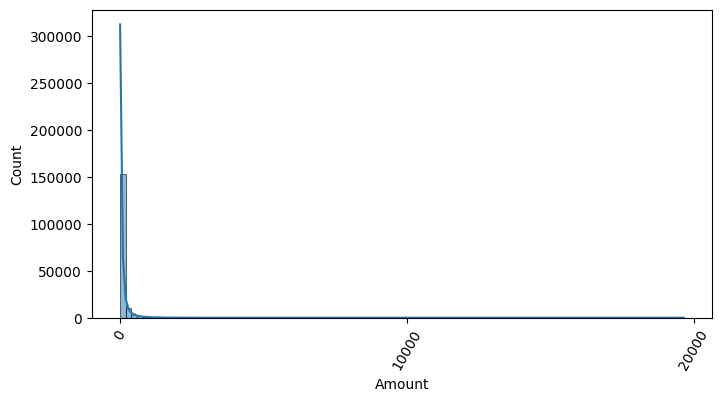

In [12]:
plt.figure (figsize=(8,4))
plt.xticks(range(0, 30000, 10000), rotation=60)
sns.histplot(train['Amount'], bins=100, kde=True)
plt.show()

### 1.2. 결측치 확인

In [13]:
for col in train.columns:
    msg = 'column: {:>10}\t Percentage of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

# This loop iterates through every column in the train DataFrame
# and prints the percentage of missing (NaN) values for each column.
#
# 1. train.columns → retrieves all column names in the DataFrame
# 2. train[col].isnull().sum() → counts the number of NaN values in that column
# 3. train[col].shape[0] → gives the total number of rows in that column
# 4. (NaN count / total rows) * 100 → calculates the percentage of missing values
# 5. String formatting (format) is used to align and format the output:
#    - {:>10} → right-aligns the column name in a field of width 10
#    - {:.2f}% → displays the percentage with two decimal places


column:         id	 Percentage of NaN value: 0.00%
column:       Time	 Percentage of NaN value: 0.00%
column:         V1	 Percentage of NaN value: 0.00%
column:         V2	 Percentage of NaN value: 0.00%
column:         V3	 Percentage of NaN value: 0.00%
column:         V4	 Percentage of NaN value: 0.00%
column:         V5	 Percentage of NaN value: 0.00%
column:         V6	 Percentage of NaN value: 0.00%
column:         V7	 Percentage of NaN value: 0.00%
column:         V8	 Percentage of NaN value: 0.00%
column:         V9	 Percentage of NaN value: 0.00%
column:        V10	 Percentage of NaN value: 0.00%
column:        V11	 Percentage of NaN value: 0.00%
column:        V12	 Percentage of NaN value: 0.00%
column:        V13	 Percentage of NaN value: 0.00%
column:        V14	 Percentage of NaN value: 0.00%
column:        V15	 Percentage of NaN value: 0.00%
column:        V16	 Percentage of NaN value: 0.00%
column:        V17	 Percentage of NaN value: 0.00%
column:        V18	 Percentage 

### 1.3 이상치 탐지 및 제거하기

In [14]:
# 1. 이상치 탐지 함수 (Outlier Detection)
# IQR(사분위 범위)을 사용하여 소수 클래스(사기) 내의 이상치를 탐지.

def get_outlier(df: pd.DataFrame, column: str, weight: float = 1.5) -> np.ndarray:
    """
    특정 컬럼에서 IQR 방식으로 이상치 행 인덱스를 반환합니다.
    (이 프로젝트에서는 'Class'가 1인 사기 데이터만을 기준으로 이상치를 탐지합니다.)

    Args:
        df: 입력 데이터프레임
        column: 이상치 탐지 기준이 될 컬럼 이름
        weight: IQR 범위에 적용할 가중치 (기본값 1.5)

    Returns:
        이상치로 판단된 행의 인덱스 배열
    """
    # 사기(Class=1) 데이터만 추출
    fraud = df[df["Class"] == 1][column]

    # IQR 계산
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75 - q25
    iqr_weight = iqr * weight

    # 이상치 범위 설정
    lower_bound = q25 - iqr_weight
    upper_bound = q75 + iqr_weight

    # 이상치에 해당하는 인덱스 추출
    outlier_idx = fraud[(fraud < lower_bound) | (fraud > upper_bound)].index
    return outlier_idx


# 2. 전처리 함수 (통합 버전)
def get_preprocessed_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Credit Card Fraud Detection 데이터 전처리 과정을 수행합니다.
    1. 'Amount' 컬럼에 로그 변환을 적용한 'Amount_Scaled' 컬럼을 삽입합니다.
    2. 불필요한 'Time'과 원래 'Amount' 컬럼을 제거합니다.
    3. 'V14' 컬럼 기준으로 탐지된 이상치를 제거합니다.

    Args:
        df: 원본 데이터프레임

    Returns:
        전처리가 완료된 데이터프레임
    """
    df_copy = df.copy()

    # 로그 변환된 Amount_Scaled 삽입 (로그 변환은 데이터 분포를 정규화하여 모델 성능 향상에 도움)
    df_copy.insert(0, 'Amount_Scaled', np.log1p(df_copy['Amount']))

    # 불필요한 열 제거
    # 'Time'은 선형적 시간 정보이며, 'Amount'는 스케일링된 버전으로 대체되었으므로 제거
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)

    # V14 기준으로 이상치 제거 (V14는 사기와 높은 연관성을 보이는 PCA 변수)
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(index=outlier_index, inplace=True)

    return df_copy


# 3. 학습/테스트셋 분리 함수
def get_train_test_dataset(df: pd.DataFrame):
    """
    전처리된 데이터프레임을 학습(Train) 및 테스트(Test) 세트로 분리합니다.
    Nan 값이 포함된 행은 제거합니다.

    Args:
        df: 원본 데이터프레임

    Returns:
        X_train, X_test, y_train, y_test (특징 및 타겟 데이터 세트)
    """
    df_copy = get_preprocessed_df(df)

    # Drop rows with NaN in the target variable ('Class')
    df_copy.dropna(subset=['Class'], inplace=True)

    # 마지막 컬럼('Class')을 타겟(y)으로, 나머지를 특징(X)으로 설정
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    # Stratify=y_target을 사용하여 타겟 클래스(사기/정상) 비율을 유지하며 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

In [15]:
#backup 파일 만들어두기
train2 = train.copy()

In [16]:
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [17]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.790998
1     0.209002
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.791277
1     0.208723
Name: count, dtype: float64


### 1.4. Testing

In [18]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    """모델의 예측 성능을 평가하는 함수"""
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    # 결과를 보기 좋게 출력합니다.
    print('오차 행렬 (Confusion Matrix)')
    print(confusion)
    print(f'정확도(Accuracy): {accuracy:.4f}, 정밀도(Precision): {precision:.4f}')
    print(f'재현율(Recall): {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

In [19]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

### 1.4.1. 로지스틱 회귀로 확인

In [20]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행.
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬 (Confusion Matrix)
[[51143    14]
 [   43    64]]
정확도(Accuracy): 0.9989, 정밀도(Precision): 0.8205
재현율(Recall): 0.5981, F1-Score: 0.6919, ROC AUC: 0.9274


### 1.4.2. Light GBM로 확인

In [21]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [22]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,  verbose=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬 (Confusion Matrix)
[[51153     4]
 [   18    89]]
정확도(Accuracy): 0.9996, 정밀도(Precision): 0.9570
재현율(Recall): 0.8318, F1-Score: 0.8900, ROC AUC: 0.9769


### 1.4.3. XG BOOSTER로 확인

In [23]:
from xgboost import XGBClassifier

# 1. XGBoost 분류기 생성
xgb_clf = XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='logloss', random_state=42)

# 2. 모델 학습
xgb_clf.fit(X_train, y_train)

# 3. 예측
xgb_pred = xgb_clf.predict(X_test)
xgb_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# 4. 평가
get_clf_eval(y_test, xgb_pred, xgb_pred_proba)

오차 행렬 (Confusion Matrix)
[[51126    31]
 [   24    83]]
정확도(Accuracy): 0.9989, 정밀도(Precision): 0.7281
재현율(Recall): 0.7757, F1-Score: 0.7511, ROC AUC: 0.9107


## 2. Feacture Engineering
* 결측치, 이상치 등 데이터 정제가 적절하게 수행되었는가?
* 데이터 스케일링 및 인코딩 등이 적절히 수행되었는가?

<Axes: >

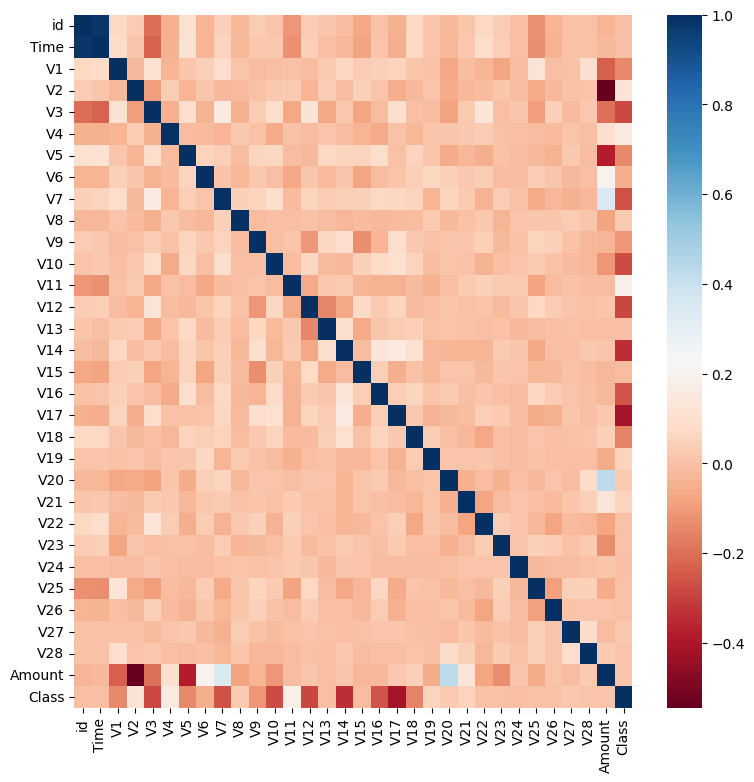

In [24]:
plt.figure(figsize=(9, 9))
corr = train.corr()
sns.heatmap(corr, cmap='RdBu')

#음의 상관관계가 높을 수록 빨간색, V17에 해당하는 경우만 이상치를 찾아서 제거하기

In [25]:
# V1부터 V28까지 이상치 인덱스 출력
for i in range(1, 29):
    col_name = f'V{i}'

    # 데이터에 없는 컬럼이 있을 경우 건너뛰기 (예: V13이 없거나 제거된 경우)
    if col_name not in train.columns:
        print(f'{col_name} 컬럼 없음 - 건너뜀')
        continue

    outlier_index = get_outlier(df=train, column=col_name, weight=1.5)
    print(f'{col_name} 이상치 데이터 인덱스:', outlier_index.tolist())

#그러나 이상치 제거가 정확도

V1 이상치 데이터 인덱스: [15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 44270, 151006, 151007, 151008, 151009, 153835, 154234, 154371, 154587, 154684]
V2 이상치 데이터 인덱스: [15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 82400, 151006, 151007, 151008, 151009, 153823, 153835, 154234, 154371, 154587, 154684]
V3 이상치 데이터 인덱스: [16780, 17317, 17366, 17407, 17453, 17480, 151006, 151007, 151008, 151009]
V4 이상치 데이터 인덱스: []
V5 이상치 데이터 인덱스: [15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 151006, 151007, 151008, 151009, 154286, 154587, 154684]
V6 이상치 데이터 인덱스: [6971, 89190, 102441, 102442, 102443, 102444, 102445, 102446, 154371, 154587, 154684]
V7 이상치 데이터 인덱스: [151006, 151007, 151008, 151009, 153823, 153835, 154234, 154371, 154587, 154684]
V8 이상치 데이터 인덱스: [14170, 14197, 14211, 15166, 15204, 15225, 15451, 15476, 15506, 15539, 15566, 15736, 15751, 15781, 15810, 16780, 17317, 17366, 17407, 17453, 17480, 42784, 42

In [26]:
# ✅ 이상치 탐지 함수 (V14만)
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df["Class"]==1][column]
    q25 = np.percentile(fraud.values, 25)
    q75 = np.percentile(fraud.values, 75)
    iqr = q75 - q25
    iqr_weight = iqr * weight
    lowest_val = q25 - iqr_weight
    highest_val = q75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

# ✅ 전처리 함수 (로그 변환 + V14만 이상치 제거)
def get_preprocessed_df(df):
    df_processed = df.copy()
    df_processed.insert(0, 'Amount_Scaled', np.log1p(df_processed['Amount']))
    df_processed.drop(['Time', 'Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df_processed, column='V14', weight=1.5)
    df_processed.drop(index=outlier_index, inplace=True)
    return df_processed

# 학습/테스트 분리 함수
def get_train_test_dataset(df):
    df_cleaned = get_preprocessed_df(df)
    X = df_cleaned.drop(columns=['Class'])
    y = df_cleaned['Class']
    return train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# 평가 함수
def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    confusion = confusion_matrix(tgt_test, pred)
    accuracy = accuracy_score(tgt_test, pred)
    precision = precision_score(tgt_test, pred)
    recall = recall_score(tgt_test, pred)
    f1 = f1_score(tgt_test, pred)
    roc_auc = roc_auc_score(tgt_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, f1스코어: {f1:.4f}, roc-auc: {roc_auc:.4f}")

## 3. 모델 학습 및 평가

In [27]:
# 데이터 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

# SMOTE 적용
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [28]:
# 모델 학습 및 평가
print("### 로지스틱 회귀 예측 성능 ###")
lr_model = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_model, X_train_over, X_test, y_train_over, y_test)

print("\n### LightGBM 예측 성능 ###")
lgbm_model = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_model, X_train_over, X_test, y_train_over, y_test)

print("\n### XGBoost 예측 성능 ###")
xgb_model = XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='logloss', random_state=42)
get_model_train_eval(xgb_model, X_train_over, X_test, y_train_over, y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[50559   598]
 [   13    94]]
정확도: 0.9881, 정밀도: 0.1358, 재현율: 0.8785, f1스코어: 0.2353, roc-auc: 0.9698

### LightGBM 예측 성능 ###
오차 행렬
[[51146    11]
 [   17    90]]
정확도: 0.9995, 정밀도: 0.8911, 재현율: 0.8411, f1스코어: 0.8654, roc-auc: 0.9793

### XGBoost 예측 성능 ###
오차 행렬
[[51145    12]
 [   15    92]]
정확도: 0.9995, 정밀도: 0.8846, 재현율: 0.8598, f1스코어: 0.8720, roc-auc: 0.9821


In [29]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 그리드
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000]
}

lgbm_param_grid = {
    'num_leaves': [31, 64],
    'max_depth': [-1, 5],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 300]
}

xgb_param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 300],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 튜닝
print("🔍 튜닝 중...")

lr_gs = GridSearchCV(LogisticRegression(), lr_param_grid, scoring='f1', cv=3, n_jobs=-1)
lgbm_gs = GridSearchCV(LGBMClassifier(boost_from_average=False), lgbm_param_grid, scoring='f1', cv=3, n_jobs=-1)
xgb_gs = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, scoring='f1', cv=3, n_jobs=-1)

lr_gs.fit(X_train_over, y_train_over)
lgbm_gs.fit(X_train_over, y_train_over)
xgb_gs.fit(X_train_over, y_train_over)

# 최적 모델
best_lr = lr_gs.best_estimator_
best_lgbm = lgbm_gs.best_estimator_
best_xgb = xgb_gs.best_estimator_

# 평가
print("\n✅ 최종 평가 결과:")
print("\n### Logistic Regression (Best) ###")
get_model_train_eval(best_lr, X_train_over, X_test, y_train_over, y_test)

print("\n### LightGBM (Best) ###")
get_model_train_eval(best_lgbm, X_train_over, X_test, y_train_over, y_test)

print("\n### XGBoost (Best) ###")
get_model_train_eval(best_xgb, X_train_over, X_test, y_train_over, y_test)


🔍 튜닝 중...

✅ 최종 평가 결과:

### Logistic Regression (Best) ###
오차 행렬
[[50650   507]
 [   14    93]]
정확도: 0.9898, 정밀도: 0.1550, 재현율: 0.8692, f1스코어: 0.2631, roc-auc: 0.9715

### LightGBM (Best) ###
오차 행렬
[[51146    11]
 [   17    90]]
정확도: 0.9995, 정밀도: 0.8911, 재현율: 0.8411, f1스코어: 0.8654, roc-auc: 0.9812

### XGBoost (Best) ###
오차 행렬
[[51144    13]
 [   15    92]]
정확도: 0.9995, 정밀도: 0.8762, 재현율: 0.8598, f1스코어: 0.8679, roc-auc: 0.9823


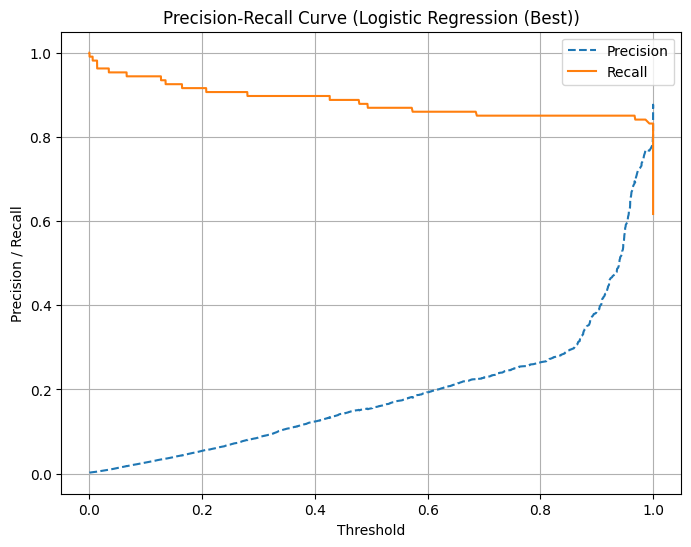

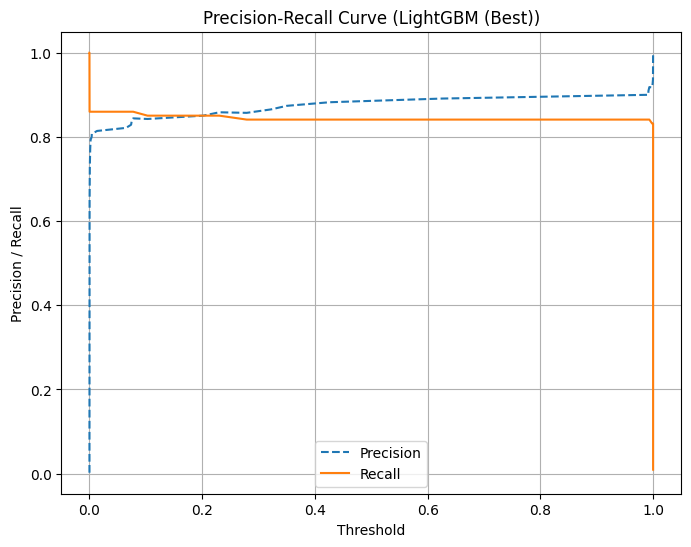

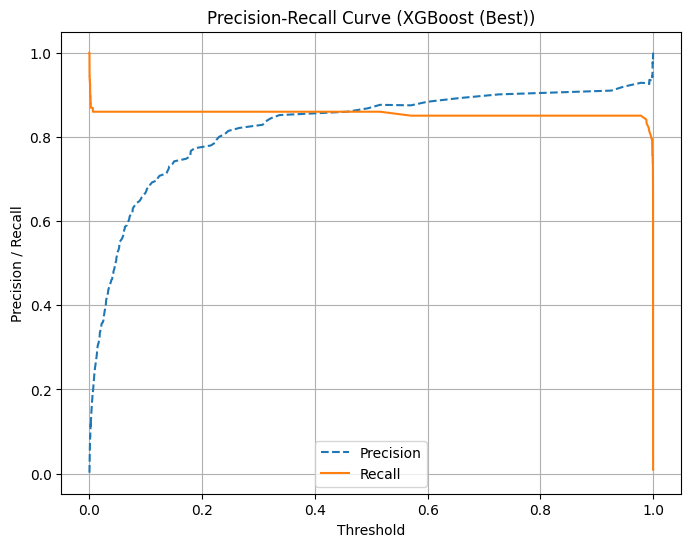

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# PR 커브 시각화 함수
def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[:threshold_boundary], label='Recall')
    plt.xlabel('Threshold'); plt.ylabel('Precision / Recall')
    plt.title('Precision-Recall Curve (XGBoost Best)')
    plt.legend(); plt.grid(); plt.show()

# XGBoost 확률 예측값 기반 커브 그리기
pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_xgb)



In [35]:
# 테스트 데이터 전처리 (로그 변환만 하고 Time, Amount 제거. id는 유지)
def preprocess_test_df(df):
    df_processed = df.copy()
    df_processed.insert(0, 'Amount_Scaled', np.log1p(df_processed['Amount']))
    df_processed.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_processed

# 전처리 적용
test_processed = preprocess_test_df(test)

# sample_submission 불러오기
submission = pd.read_csv('/content/sample_submission.csv')

# XGBoost 예측 (❗ id 포함된 test_processed 사용)
submission['Class'] = best_xgb.predict_proba(test_processed)[:, 1]

# 제출 파일 저장
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv 저장 완료 — 캐글에 제출하면 돼요!")

✅ submission.csv 저장 완료 — 캐글에 제출하면 돼요!
